# Solving for T(R) and c(R): balancing solid growth and diffusion from the F-layer

Our particle growth calculations can yield solid growth rates
along the trajectory and we can relate this to the production of
heat and oxygen from crystal growth as a function of height above
the ICB. Here we seek to treat these as source terms in a
balance between the heat production (and oxygen content)
with diffusion out of the F-layer.
The idea is that we can then proceed in an iterative manner: (1) 
Set a temperature and composition profile. (2) Calculate the
heat and oxygen production rate (by considering the particle 
falling and growing problem for all nucleation radii).
(3) Find a temperature and
composition profile that is consistent with this production rate
and allows the heat and oxygen production to be balanced by diffusion
out of the layer. (4) Feed the profiles from (3) back into
(2) and repeat until convergence. Both heat and oxygen production in
the layer will lead to an increase in the temperature and oxygen content
of the layer. Both changes will tend to reduce driving force for nucleation
and growth so we will have fewer particles and slower nucleation, hence 
slowing the approach to equilibrium. However,
the equilibrium solid content will also reduce (potentially all the way to
zero if the whole layer ends up on the liquidus) so the F-layer will be
closer to equilibrium for the same solid content. With luck we'll converge
to a solution in a few iterations.

This notebook outlines the development of the solver for step (3)
in a way that is decoupled from the rest of the code. Note that the
same solver can be used for the two systems (just exchanging chemical 
and thermal diffusivity and choosing different boundary conditions and
source terms) and these can be treated separately unless we want to 
couple e.g. thermal conduction and oxygen content of the melt. We
neglect Soret effects, assume that the liquid is stably 
stratified (so no heat or chemical transfer via convection),
and that the falling particles are always in thermal equilibrium
(the temperature of the particles is the same as the temperature
of the stratified liquid). 

# Solving for T(R) and c(R): balancing solid growth and diffusion from the F-layer

Our particle growth calculations can yield solid growth rates
along the trajectory and we can relate this to the production of
heat and oxygen from crystal growth as a function of height above
the ICB. Here we seek to treat these as source terms in a
balance between the heat production (and oxygen content)
with diffusion out of the F-layer.
The idea is that we can then proceed in an iterative manner: (1) 
Set a temperature and composition profile. (2) Calculate the
heat and oxygen production rate (by considering the particle 
falling and growing problem for all nucleation radii).
(3) Find a temperature and
composition profile that is consistent with this production rate
and allows the heat and oxygen production to be balanced by diffusion
out of the layer. (4) Feed the profiles from (3) back into
(2) and repeat until convergence. Both heat and oxygen production in
the layer will lead to an increase in the temperature and oxygen content
of the layer. Both changes will tend to reduce driving force for nucleation
and growth so we will have fewer particles and slower nucleation, hence 
slowing the approach to equilibrium. However,
the equilibrium solid content will also reduce (potentially all the way to
zero if the whole layer ends up on the liquidus) so the F-layer will be
closer to equilibrium for the same solid content. With luck we'll converge
to a solution in a few iterations.

This notebook outlines the development of the solver for step (3)
in a way that is decoupled from the rest of the code. Note that the
same solver can be used for the two systems (just exchanging chemical 
and thermal diffusivity and choosing different boundary conditions and
source terms) and these can be treated separately unless we want to 
couple e.g. thermal conduction and oxygen content of the melt. We
neglect Soret effects, assume that the liquid is stably 
stratified (so no heat or chemical transfer via convection),
and that the falling particles are always in thermal equilibrium
(the temperature of the particles is the same as the temperature
of the stratified liquid). 

In [1]:
# Imports and system setup
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


## Heat production balances thermal diffusion

Our falling particles liberate heat as they fall and grow. By assumption this heat production is balanced by diffusion of heat out
of the F-layer and the temperature of the layer does not change with time. For our spherical geometry we need to find the
temperature profile which satisfies:

$$\frac{\mathrm{d} T(R)}{\mathrm{d} t} \rho c_p =  
    H(R) + \frac{1}{R^2}\frac{\mathrm{d}}{\mathrm{d} R}\left(k R^2 \frac{\mathrm{d} T(R)}{\mathrm{d} R} \right)
        = 0 $$

where $k$ is the thermal conductivity, $c_p$ is the *specific* heat capacity, $\rho$ is the density and $H(R)$ a specified (and
temperature independent) function defining the heat production rate (in W/m^3). $H$ is calculated by multiplying the volume production rate of solid (in $m^3/m^3$) by the density and the latent heat. The heat capacity, density and conductivity 
ought to relate to the slurry as a whole and be a weighted average of the solid and liquid, but as the solid fraction is low
we will neglect the effect of the solid on these terms. We further assume that the conductivity is independent of pressure
and temperature. We seek $T(R)$ that solves this equation for specified boundary conditions (see below).

**The equation above is probably the only one we need in the manuscript, with a brief note on how it is solved and the BCs.
I'll remove *this* note once I've written that text**


### Boundary conditions

I imagine that the temperature at the top of the layer is defined by the rapidly convecting bulk of the 
outer core. Heat can be rapidly removed from this boundary. We can sensibly impose a fixed temperature
boundary condition at the top of the layer (set to the intersection of the liquidus and the adiabat
at the top of the F-layer). Whatever we do about the lower boundary condition, this also means we can
evaluate the heat flux out of the layer from the temperature gradient on this boundary, allowing the
possibility of coupling our F-layer model to a longer-timescale thermal evolution model of the cooling
of the core.

I suppose one day there may be call for a fixed gradient boundary condition on the upper interface.
One example would be a snow zone just below the core-mantle boundary where conduction in the mantle
sets the heat flux out of the core (e.g. on a small planet).

The correct boundary condition at the bottom of the F-layer is a little less obvious. I think it
depends on how we think the inner core grows, what we impose about the behavior of the inner core,
and potentially what is numerically convenient.

One way forward would be saying, for the sake of argument, that the inner core only grows by
sedimentation, that the growth rate is an output of the F-layer model, and that the inner core
is isothermal. In this case, the heat flux out of the inner core will be zero, and the boundary 
condition will be zero thermal gradient on the lower boundary.

An alternative setup would be to set the growth rate of the inner core, subtract the growth
rate due to sedimentation, and calculate the heat released at the lower boundary by direct
growth. This would result in a lower boundary condition with a non-zero thermal gradient.
This seems like a sensible setup, but one issue may be that some of our solutions give
enormous growth rates due to sedimentation and this would need to be balanced by melting
at the ICB to such that the growth rate matches the imposed rate. Even if this makes
physical sense, I suspect it won't lead to an overall problem that converges.

The third possibility is to set the temperature at the lower boundary. This would
imply some background thermal conduction across the F-layer (zero if we chose the
adiabatic temperature) and could allow heat to be conducted from the F-layer 
into the inner core. This may be sensible, may yield solutions that are easier
to check, and would be the natural setup for a shallow snow zone. 

What I've done is implement a solver that allows either fixed temperature gradient
or fixed temperature on the top and bottom boundary. The setup phase of the problem
just checks that one condition is set at each boundary.

### Numerical solution

We're finding $T(R)$ given a second order ordinary differential equation and
two boundary conditions. This can be done numerically using a collocation scheme
implemented as `scipy.integrate.solve_bvp`. What we need to do is write the 
second order ODE as a system of two coupled first order equations, define these
and the boundary condition residuals as functions (binding $H(R)$ to the 
first function) and pass these into the solver with an initial guess at the
solution (as values on an initial set of mesh points). We get back a new
set of mesh points, a continuous spline representing the solution ($T(R)$
and $dT(R)/dT$) as well as these solutions on a refined set of mesh points.

To write the second order ODE as a system of two first order equations we 
first expanded and simplify:

$$H(R) + \frac{1}{R^2} \left[ k R^2 \frac{\mathrm{d}^2 T}{\mathrm{d} R^2} 
    + 2 k R \frac{\mathrm{d} T}{\mathrm{d} R}\right] = 0,$$

$$H(R) + k \frac{\mathrm{d}^2 T}{\mathrm{d} R^2} 
    + \frac{2 k}{ R} \frac{\mathrm{d} T}{\mathrm{d} R} = 0.$$
    
    
Then make the substitutions $y_0 = T$ and $y_1 = \frac{\mathrm{d} T}{\mathrm{d} R}$ so that
 $y_1^{\prime} = \frac{\mathrm{d}^2 T}{\mathrm{d} R^2}$. Then:

$$H(R) + k y_1^{\prime} + \frac{2 k}{ R} y_1 = 0$$

We can then express the system of equations as:

$$y_0^{\prime} = y_1$$

$$y_1^{\prime} = \frac{- H(R) - (2 k / R) y_1}{k}$$

I'm using $y_0$ and $y_1$, rather than 1 and 2, to match python's index 
notation, will accept $Q(R)$ (which is the volumetric heat production
rate in W m$^{-3}$) as an array of values along with arrays representing 
$R$ and the initial guesses for $T$ and $\frac{\mathrm{d} T}{\mathrm{d} R}$.
All four arrays need to be the same length and two (out of four) boundary
conditions must be supplied.

This all gets implemented inside of `layer_diffusion.solve_layer_diffusion`,
which comes with the ability to plot on matplotlib Axes (if we supply three).
Examples are below.

## Composition

$$\frac{\mathrm{d} c(R)}{\mathrm{d}t} \rho = c(R) m^s(R) + \frac{1}{R^2} \frac{\mathrm{d}}{\mathrm{d}R}\left(\rho D_L R^2 \frac{\mathrm{d} c(R)}{\mathrm{d}R} \right) = 0$$

For composition we have a volumentic solid production rate and X, the mol fraction Fe in the melt.

The first thing to do is convert the volumetic production rate into a mass production rate, $m^s$, by
multiplying by the density. This has units of kg m$^{-3}$ s$^{-1}$. 

The second task is to convert X into c, the mass fraction FeO. We have helper functions for this.

Then we can use much of the same machinary as for the thermal case replacing  $k$ with $\rho D_L$.. However, we cannot just replace H(R) with $c(r)m^s(R)$, because we solve for $c(R)$. Instead we alter the second ODE to read:

$$y_1^{\prime} = \frac{- y_0 m^s(R) - (2 (\rho D_L) / R) y_1}{(\rho D_L)}$$


 Before returning from the function we need to convert $c(R)$ into $X(R)$ and
which we can use to compute the misfit.




In [2]:
import layer_diffusion

r_icb = 1221.5e3
f_layer_thickness = 200.0e3
r = np.linspace(r_icb, r_icb+f_layer_thickness, num=50)

## Test case 1

This is something simple. No heat sources and fixed temperature BCs at the top and bottom.

The curvature on the solution is due to the spherical shell geometry.

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.95e-11       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 2.95e-11 
Maximum boundary residual: 0.00e+00


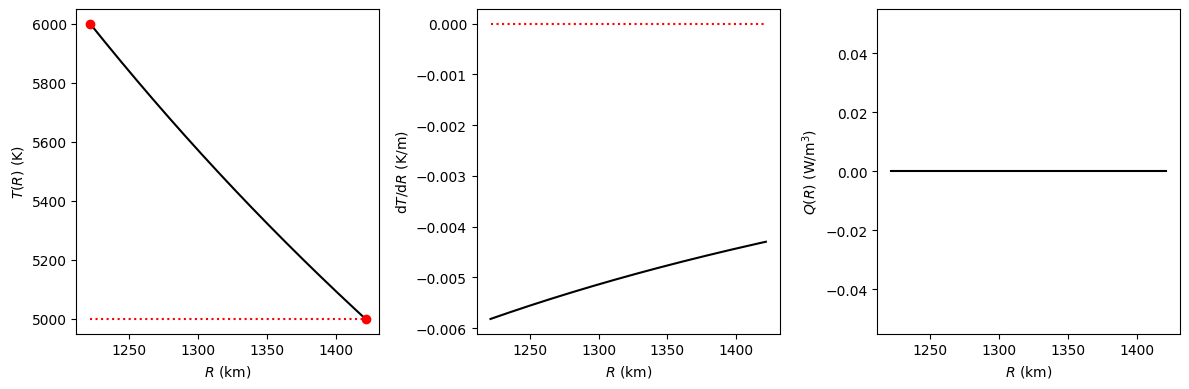

In [3]:
k     = 100.0                    # thermal conductivity of iron, W/m/K 
heat_sources = np.zeros_like(r)

t_top = 5000.0
t_bottom = 6000.0
initial_t = np.ones_like(r) * t_top

fig, axs = plt.subplots(ncols=3, figsize=(12,4))

out_ts = layer_diffusion.solve_layer_diffusion(r, heat_sources, k, initial_t, 
                                               top_value_bc=t_top, bottom_value_bc=t_bottom, fig_axs=axs)

fig.tight_layout()
plt.show()

## Test case 2

This just like case 1, but with a much bigger radius (so the geometry effect is smaller).

The thermal gradient should be approximately dT/dR = (5000-6000)/200000 = -0.005 K/m^3 everywhere.


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.03e-16       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 2.03e-16 
Maximum boundary residual: 0.00e+00


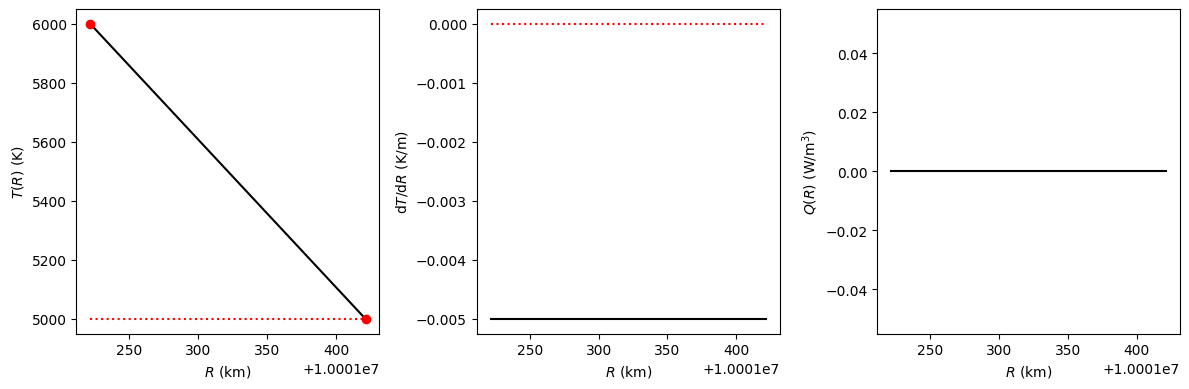

In [4]:
big_r = r + 1.0E10
k     = 100.0                    # thermal conductivity of iron, W/m/K 
heat_sources = np.zeros_like(big_r)

t_top = 5000.0
t_bottom = 6000.0
initial_t = np.ones_like(big_r) * t_top

fig, axs = plt.subplots(ncols=3, figsize=(12,4))

out_ts = layer_diffusion.solve_layer_diffusion(big_r, heat_sources, k, initial_t, 
                                               top_value_bc=t_top, bottom_value_bc=t_bottom, fig_axs=axs)

fig.tight_layout()
plt.show()

## Test case 3

This is something a bit like we may expect. Fixed T BC at the top and zero gradient
at the bottom. Heat sources distributed evenly 
in the layer (but zero on the boundaries). Try with a uniform initial guess
at the temperature (in this case not matching the boundary condition at the top)
and an initial non-zero derivative (not matching the temperature or boundary conditions).
matching the boundary condition at the bottom). 

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.56e-09       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 1.56e-09 
Maximum boundary residual: 0.00e+00


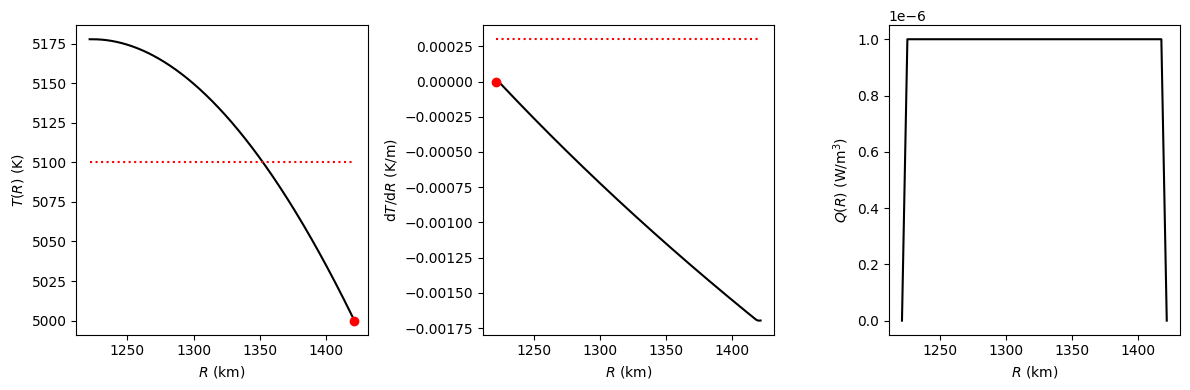

In [5]:
k     = 100.0                    # thermal conductivity of iron, W/m/K 

heat_sources = np.ones_like(r) * 1.0E-6 # W m^-3
heat_sources[0] = 0.0
heat_sources[-1] = 0.0

t_top = 5000.0
initial_t = np.ones_like(r) * t_top + 100
initial_dtdr = np.zeros_like(r) + 0.0003

fig, axs = plt.subplots(ncols=3, figsize=(12,4))

out_ts = layer_diffusion.solve_layer_diffusion(r, heat_sources, k, initial_t, derivative_guess=initial_dtdr, 
                                               top_value_bc=t_top, bottom_derivative_bc=0.0, fig_axs=axs)

fig.tight_layout()
plt.show()

## Test case 4

Something approximating no slurry, put all heat sources on the lower boundary. 
Keep the  uniform initial guess at the temperature (matching the boundary condition at the top) and thus zero derivative (matching the boundary condition at the bottom). I'll keep the total heat production rate fixed and calculate solutions with two different values for k
(black is the K=100 W/m/K solution, green is the K=10 W/m/K solution)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.88e-08       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 7.88e-08 
Maximum boundary residual: 0.00e+00
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.83e-07       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 7.83e-07 
Maximum boundary residual: 0.00e+00


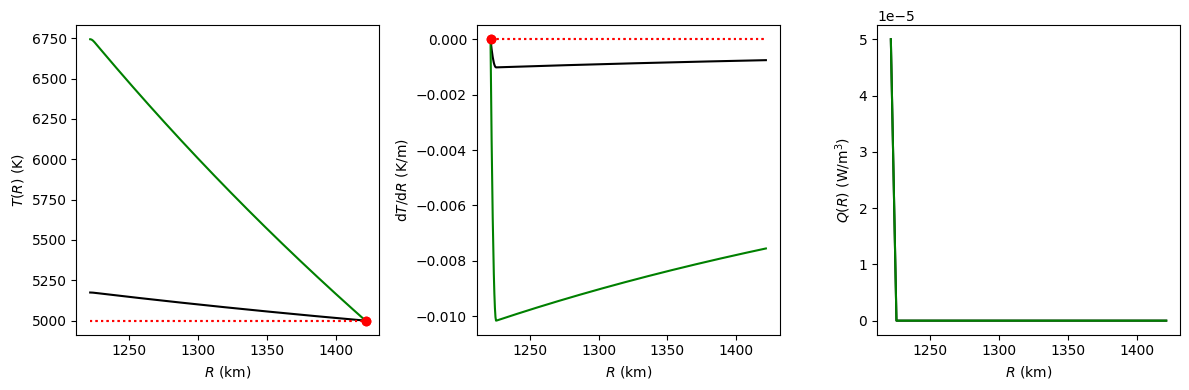

In [6]:
heat_sources = np.zeros_like(r) 
heat_sources[0] = r.size * 1.0E-6 # W m^-3
heat_sources[-1] = 0.0


t_top = 5000.0
initial_t = np.ones_like(r) * t_top

fig, axs = plt.subplots(ncols=3, figsize=(12,4))

out_ts = layer_diffusion.solve_layer_diffusion(r, heat_sources, 100, initial_t, 
                                               top_value_bc=t_top, bottom_derivative_bc=0.0, fig_axs=axs)

out_ts = layer_diffusion.solve_layer_diffusion(r, heat_sources, 10, initial_t, 
                                               top_value_bc=t_top, bottom_derivative_bc=0.0, fig_axs=axs,
                                               fig_col='g')

fig.tight_layout()
plt.show()

## Test case 5

What if we put all the heat sources in the middle of the layer (black) or in the bottom half of the layer (green)?

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.26e-08       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 7.26e-08 
Maximum boundary residual: 0.00e+00
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.27e-10       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 7.27e-10 
Maximum boundary residual: 0.00e+00


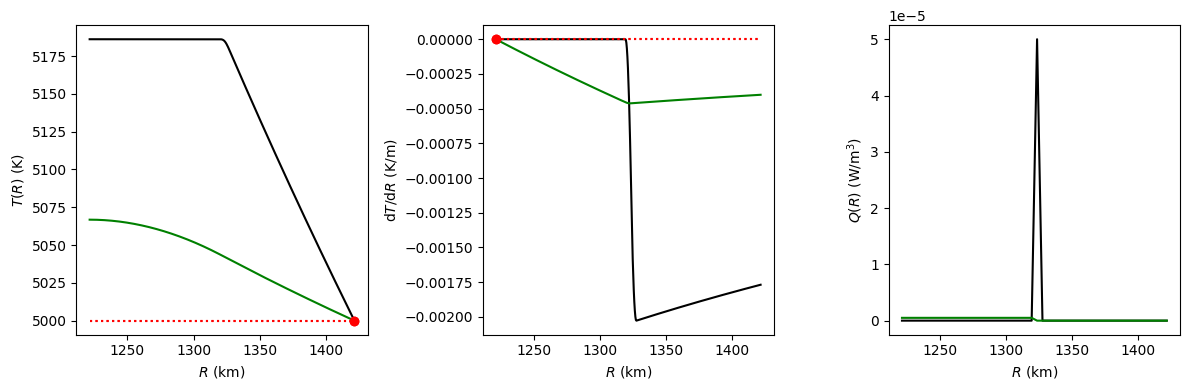

In [7]:
k = 100.0
heat_sources_black = np.zeros_like(r) 
heat_sources_black[25] = r.size * 1.0E-6 
heat_sources_green = np.zeros_like(r)
heat_sources_green[0:25] = 1.0E-6 / 2.0


t_top = 5000.0
initial_t = np.ones_like(r) * t_top

fig, axs = plt.subplots(ncols=3, figsize=(12,4))

out_ts = layer_diffusion.solve_layer_diffusion(r, heat_sources_black, k, initial_t, 
                                               top_value_bc=t_top, bottom_derivative_bc=0.0, fig_axs=axs)

out_ts = layer_diffusion.solve_layer_diffusion(r, heat_sources_green, k, initial_t, 
                                               top_value_bc=t_top, bottom_derivative_bc=0.0, fig_axs=axs,
                                               fig_col='g')

fig.tight_layout()
plt.show()

## Test case 6

Like case 5 but with fixed T on the lower boundary. We end up with some of the generated heat diffusing into the inner core
(this will depend on the chosen temperature).

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.26e-08       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 7.26e-08 
Maximum boundary residual: 0.00e+00
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.28e-10       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 7.28e-10 
Maximum boundary residual: 0.00e+00


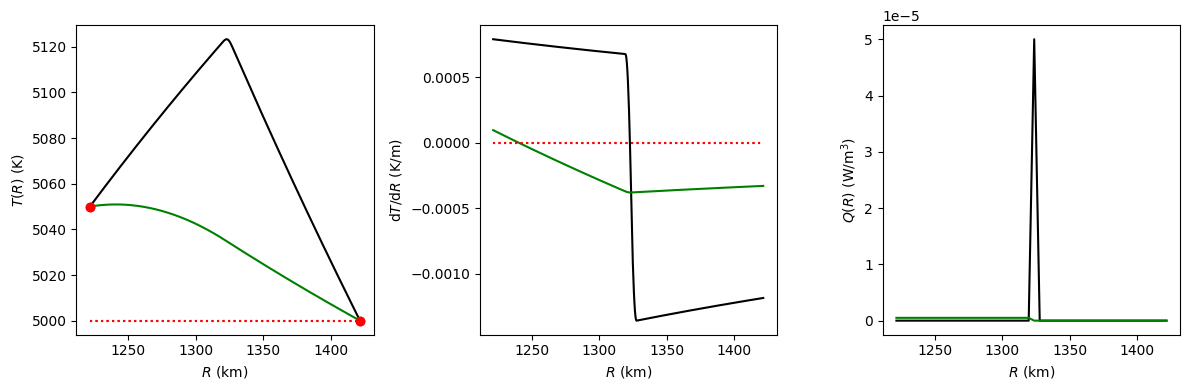

In [25]:
k = 100.0
heat_sources_black = np.zeros_like(r) 
heat_sources_black[25] = r.size * 1.0E-6 
heat_sources_green = np.zeros_like(r)
heat_sources_green[0:25] = 1.0E-6 / 2.0


t_top = 5000.0
t_bottom = 5050.0
initial_t = np.ones_like(r) * t_top

fig, axs = plt.subplots(ncols=3, figsize=(12,4))

out_ts = layer_diffusion.solve_layer_diffusion(r, heat_sources_black, k, initial_t, 
                                               top_value_bc=t_top, bottom_value_bc=t_bottom, fig_axs=axs)

out_ts = layer_diffusion.solve_layer_diffusion(r, heat_sources_green, k, initial_t, 
                                               top_value_bc=t_top, bottom_value_bc=t_bottom, fig_axs=axs,
                                               fig_col='g')

fig.tight_layout()
plt.show()

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.28e-10       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 7.28e-10 
Maximum boundary residual: 0.00e+00


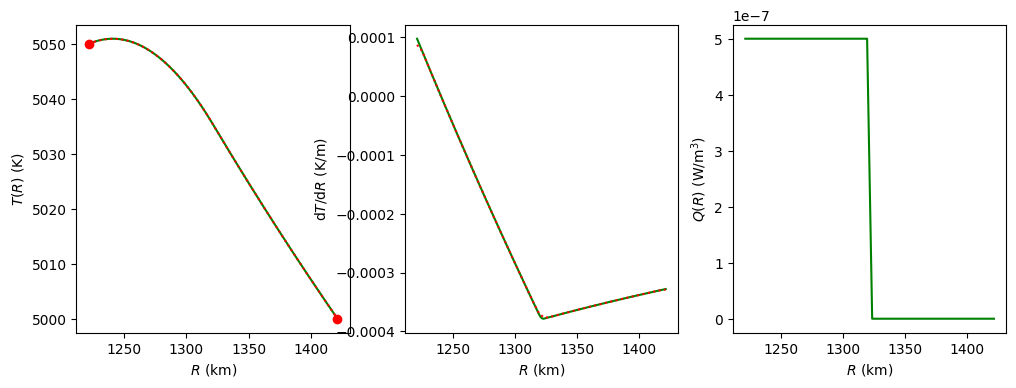

In [26]:
# Try resolving with the (green) solution as the new guess

fig, axs = plt.subplots(ncols=3, figsize=(12,4))
new_out_ts = layer_diffusion.solve_layer_diffusion(r, heat_sources_green, k, out_ts, 
                                                   top_value_bc=t_top, bottom_value_bc=t_bottom, fig_axs=axs,
                                                   fig_col='g')


## Test case 7

Like test case 3 but with chemical parameters

In [9]:
import feo_thermodynamics as feot

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.67e-11       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 2.67e-11 
Maximum boundary residual: 0.00e+00


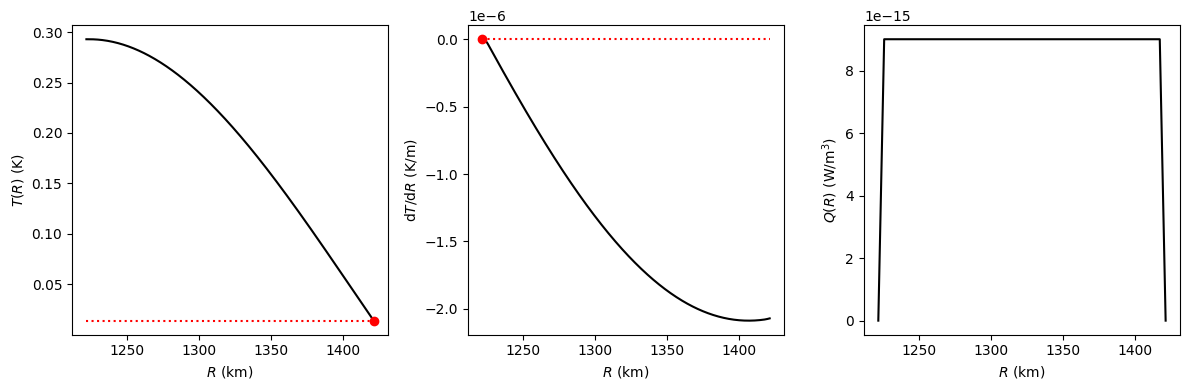

In [39]:
dl = 1.0E-8
_, _, _, fe_density, _, _ = feot.densities(1.0, 330.0, 5700.0)

mass_rate = np.ones_like(r) * 9.0E-15 # kg m^-3 s^-1 equivelent to case 7 with sensible heat
mass_rate[0] = 0.0
mass_rate[-1] = 0.0

x_top = 0.95
initial_x = np.ones_like(r) * x_top
initial_dcdr = np.zeros_like(r)

c_top = feot.mass_percent_o(x_top)/100.0
initial_c = feot.mass_percent_o(initial_x)/100.0


fig, axs = plt.subplots(ncols=3, figsize=(12,4))



out_cs = layer_diffusion.solve_layer_diffusion(r, mass_rate, dl*fe_density, initial_c, derivative_guess=initial_dcdr, 
                                               top_value_bc=c_top, bottom_derivative_bc=0.0, fig_axs=axs, composition=True)

out_xs = feot.mol_frac_fe(out_cs * 100.0)
fig.tight_layout()
plt.show()

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.67e-11       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 2.67e-11 
Maximum boundary residual: 0.00e+00


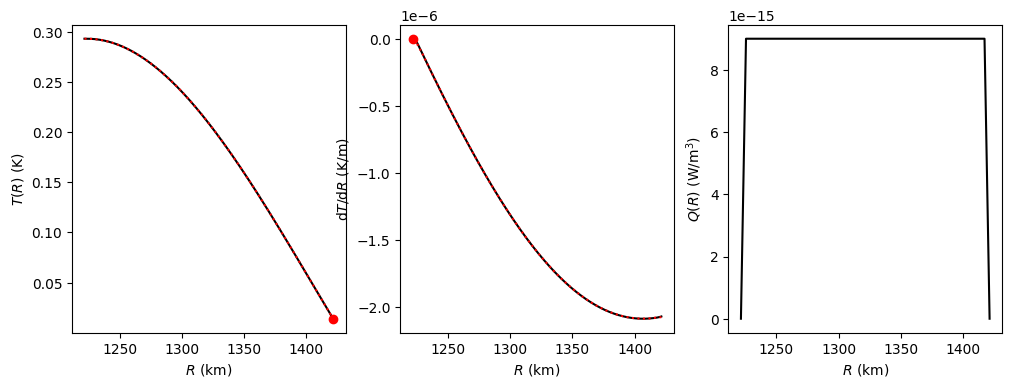

In [41]:
# Try resolving with output cs as initial guess
fig, axs = plt.subplots(ncols=3, figsize=(12,4))
new_out_cs = layer_diffusion.solve_layer_diffusion(r, mass_rate, dl*fe_density, out_cs, derivative_guess=np.gradient(out_cs, r), 
                                               top_value_bc=c_top, bottom_derivative_bc=0.0, fig_axs=axs, composition=True)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.69e-11       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 4.69e-11 
Maximum boundary residual: 0.00e+00


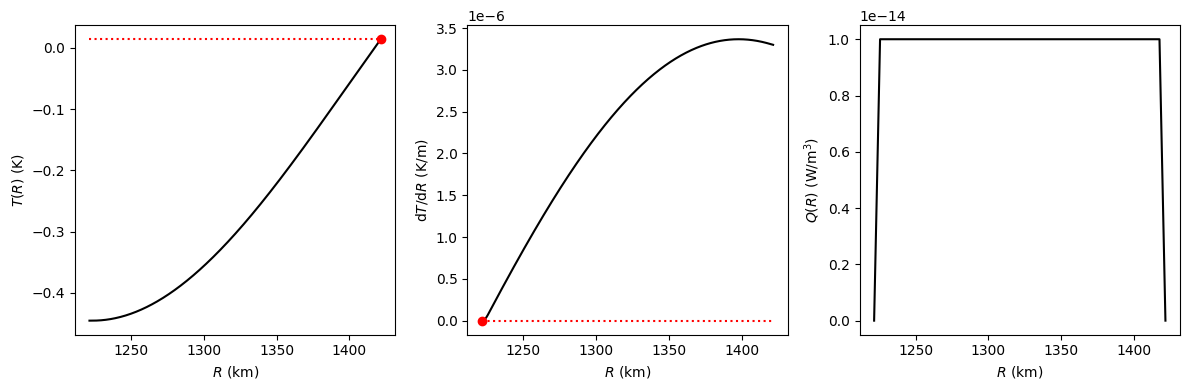

In [43]:
# 10E-15 not 9E-15 as rate
dl = 1.0E-8
_, _, _, fe_density, _, _ = feot.densities(1.0, 330.0, 5700.0)

mass_rate = np.ones_like(r) * 10.0E-15 # kg m^-3 s^-1 equivelent to case 7 with sensible heat
mass_rate[0] = 0.0
mass_rate[-1] = 0.0

x_top = 0.95
initial_x = np.ones_like(r) * x_top
initial_dcdr = np.zeros_like(r)


c_top = feot.mass_percent_o(x_top)/100.0
initial_c = feot.mass_percent_o(initial_x)/100.0
initial_dcdr = np.gradient(initial_c, r)

fig, axs = plt.subplots(ncols=3, figsize=(12,4))



out_cs = layer_diffusion.solve_layer_diffusion(r, mass_rate, dl*fe_density, initial_c, derivative_guess=initial_dcdr, 
                                               top_value_bc=c_top, bottom_derivative_bc=0.0, fig_axs=axs, composition=True)

new_out_xs = feot.mol_frac_fe(out_cs * 100.0)
fig.tight_layout()
plt.show()

# It's flipped upside down. And using the solution from 9E-15 does not help!

In [12]:
import scipy.integrate as spi
def fun(x, y):
    dy0_by_dx = y[1]
    dy1_by_dx = - y[0] 
        
    return np.vstack((dy0_by_dx, dy1_by_dx))
    
   
def bc(ya, yb):
    return np.array([ya[0] - 0.0, yb[0] - 1.0])
   
        
# Run the solver
result = spi.solve_bvp(fun, bc, np.linspace(0.0, 1.0), [np.linspace(0.0, 1.0),np.linspace(0.0, 1.0)], verbose=2)
    

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.74e-08       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 5.74e-08 
Maximum boundary residual: 0.00e+00


In [13]:
r_plot = np.linspace(0.0, 1.0, num=500)
t_plot = result.sol(r_plot)[0]

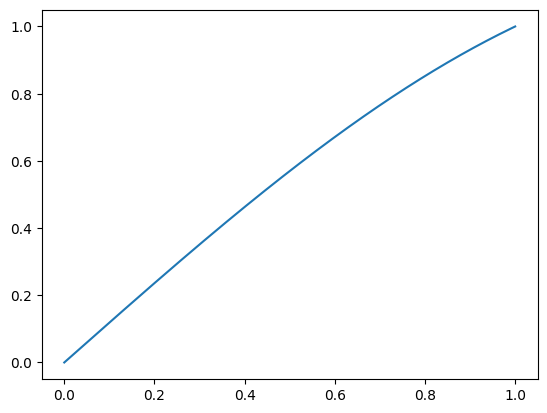

In [14]:
plt.plot(r_plot, t_plot)

## okay - wtf is going on

Things seem to go odd because of the c(r) term in the 'source'. This is like writing the 
latent heat as $S T(R)$, which we don't do for liguistic reasons. However, we expect this 
to give ossilatory solutions when the gradients have to get too big. A better solution may
be regions of negative composition, which give rise to local oxygen sinks. This is non
physical and we probably need to look at the temperature equation literature to properly
work out what is going on.

A test for this is below
where we precompute $\bar{C}(R)m^s$ and use this as a source without the variable value.
This "solves" fine for much larger source rates.

There is always a further however. It demands c(r) to go > 1 (and thus X to do some odd things
Need to check if this is physical. I suspect not!

The other option would be to use the composition at the top of the layer. But that does not help either.

But this approach would allow us to compute the characteristic polynomal and thus see something.
Or would it always give one real root? Humm.

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.62e-12       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 1.62e-12 
Maximum boundary residual: 0.00e+00
[0.19971408 0.19968514 0.19951184 0.19916629 0.19864963 0.19796296
 0.19710739 0.19608401 0.19489388 0.19353806 0.19201761 0.19033355
 0.18848689 0.18647865 0.18430981 0.18198136 0.17949426 0.17684947
 0.17404793 0.17109057 0.16797831 0.16471205 0.16129271 0.15772115
 0.15399825 0.15012488 0.14610189 0.14193013 0.13761042 0.13314359
 0.12853044 0.12377179 0.11886842 0.11382113 0.10863067 0.10329781
 0.09782332 0.09220793 0.08645239 0.08055742 0.07452375 0.06835207
 0.06204311 0.05559755 0.04901608 0.04229938 0.03544812 0.02846296
 0.02134456 0.01412252]
[0.12894793 0.12910568 0.13004986 0.1319313  0.13474142 0.13847057
 0.14310807 0.14864223 0.1550604  0.16234899 0.17049356 0.17947883
 0.18928873 0.19990647 0.21131457 0.

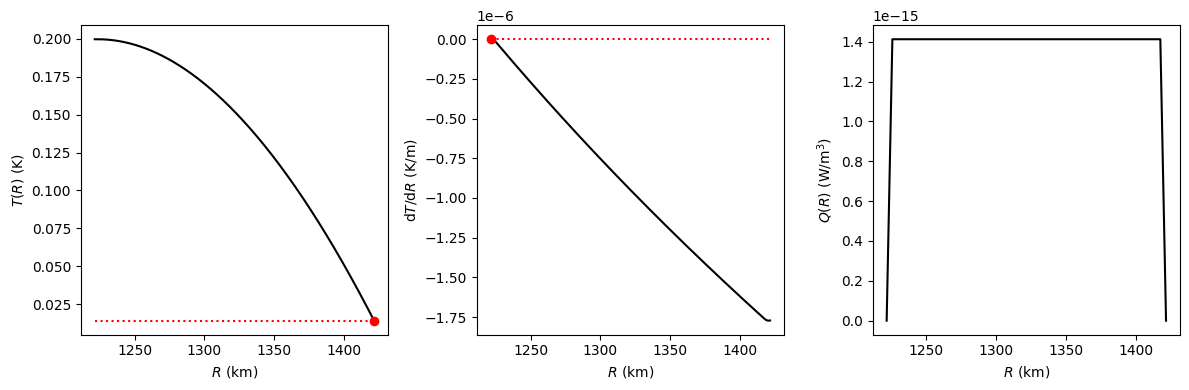

In [47]:
dl = 1.0E-8
_, _, _, fe_density, _, _ = feot.densities(1.0, 330.0, 5700.0)

# 1.0E-12 seems to work for this case (but needs big Cs)
mass_rate = np.ones_like(r) * 1.0E-13 # kg m^-3 s^-1 equivelent to case 7 with sensible heat
mass_rate[0] = 0.0
mass_rate[-1] = 0.0

x_top = 0.95
initial_x = np.ones_like(r) * x_top
initial_dcdr = np.zeros_like(r)

c_top = feot.mass_percent_o(x_top)/100.0
initial_c = feot.mass_percent_o(initial_x)/100.0


fig, axs = plt.subplots(ncols=3, figsize=(12,4))


# or mass_rate*np.mean(initial_c)
# or mass_rate*c_top
out_cs = layer_diffusion.solve_layer_diffusion(r, mass_rate*initial_c, dl*fe_density, initial_c, derivative_guess=initial_dcdr, 
                                               top_value_bc=c_top, bottom_derivative_bc=0.0, fig_axs=axs, composition=False)

print(out_cs)
out_xs = feot.mol_frac_fe(out_cs * 100.0)
print(out_xs)
fig.tight_layout()
plt.show()

/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.15e-09       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 2.15e-09 
Maximum boundary residual: 0.00e+00
[2.01874515e+02 2.01836191e+02 2.01606790e+02 2.01149588e+02
 2.00466505e+02 1.99559648e+02 1.98431307e+02 1.97083959e+02
 1.95520258e+02 1.93743039e+02 1.91755312e+02 1.89560261e+02
 1.87161243e+02 1.84561785e+02 1.81765580e+02 1.78776488e+02
 1.75598535e+02 1.72235906e+02 1.68692948e+02 1.64974166e+02
 1.61084220e+02 1.57027927e+02 1.52810256e+02 1.48436327e+02
 1.43911411e+02 1.39240925e+02 1.34430433e+02 1.29485646e+02
 1.24412414e+02 1.19216733e+02 1.13904736e+02 1.08482697e+02
 1.02957025e+02 9.73342664e+01 9.16211023e+01 8.58243460e+01
 7.99509427e+01 7.40079684e+01 6.80026278e+01 6.19422537e+01
 5.58343055e+01 4.96863678e+01 4.35061495e+01 3.73014823e+01
 3.10803199e+01 2.48507366e+01 1.86209260e+01 1.23992005e+0

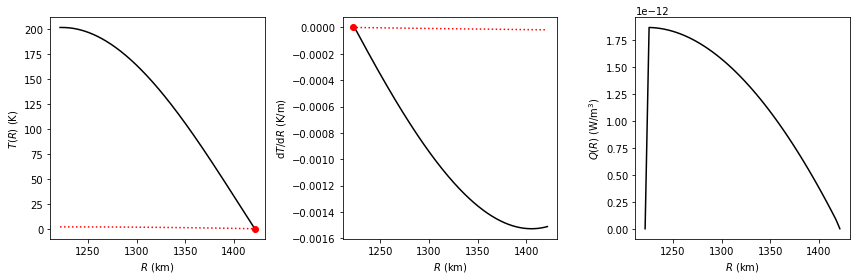

In [16]:
dl = 1.0E-8
_, _, _, fe_density, _, _ = feot.densities(1.0, 330.0, 5700.0)

mass_rate = np.ones_like(r) * 1.0E-12 # kg m^-3 s^-1 equivelent to case 7 with sensible heat
mass_rate[0] = 0.0
mass_rate[-1] = 0.0

x_top = 0.95
initial_x = np.ones_like(r) * x_top
initial_dcdr = np.zeros_like(r)

c_top = feot.mass_percent_o(x_top)/100.0
initial_c = feot.mass_percent_o(initial_x)/100.0


fig, axs = plt.subplots(ncols=3, figsize=(12,4))


# or mass_rate*np.mean(initial_c)
# or mass_rate*c_top
out_cs = layer_diffusion.solve_layer_diffusion(r, mass_rate*out_cs, dl*fe_density, out_cs, derivative_guess=np.gradient(out_cs, r), 
                                               top_value_bc=c_top, bottom_derivative_bc=0.0, fig_axs=axs, composition=False)

print(out_cs)
out_xs = feot.mol_frac_fe(out_cs * 100.0)
print(out_xs)
fig.tight_layout()
plt.show()

/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in densities (vectorized)
  outputs = ufunc(*inputs)


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.48e-09       2.26e-18          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 5.48e-09 
Maximum boundary residual: 2.26e-18
[-6.07401556e-02 -5.94984587e-02 -5.22661359e-02 -3.87302886e-02
 -2.05770398e-02 -4.24318734e-05  2.03628191e-02  3.81602487e-02
  5.12045025e-02  5.79414030e-02  5.75932502e-02  5.02480110e-02
  3.68433427e-02  1.90468371e-02 -9.50924062e-04 -2.07056597e-02
 -3.78184763e-02 -5.02268477e-02 -5.64525924e-02 -5.57780151e-02
 -4.83283443e-02 -3.50512823e-02 -1.75967126e-02  1.88834651e-03
  2.10234218e-02  3.74852058e-02  4.92896435e-02  5.50306705e-02
  5.40477134e-02  4.65011572e-02  3.33479477e-02  1.62207428e-02
 -2.77481623e-03 -2.13187867e-02 -3.71600327e-02 -4.83893800e-02
 -5.36695449e-02 -5.23942426e-02 -4.47574209e-02 -3.17249337e-02
 -1.49126785e-02  3.61360101e-03  2.15920061e-02  3.68404953e-02
  4.75215368e-0

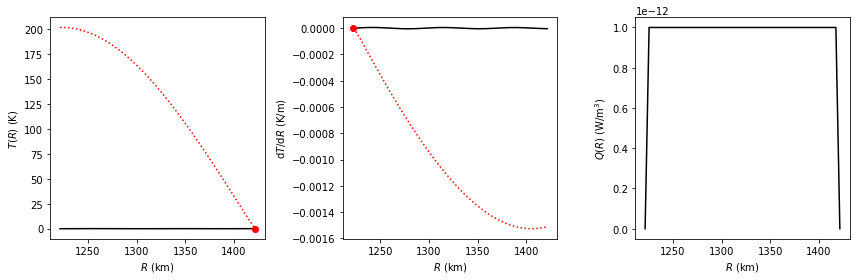

In [17]:
dl = 1.0E-8
_, _, _, fe_density, _, _ = feot.densities(1.0, 330.0, 5700.0)

mass_rate = np.ones_like(r) * 1.0E-12 # kg m^-3 s^-1 equivelent to case 7 with sensible heat
mass_rate[0] = 0.0
mass_rate[-1] = 0.0

x_top = 0.95
initial_x = np.ones_like(r) * x_top
initial_dcdr = np.zeros_like(r)

c_top = feot.mass_percent_o(x_top)/100.0
initial_c = feot.mass_percent_o(initial_x)/100.0


fig, axs = plt.subplots(ncols=3, figsize=(12,4))


# or mass_rate*np.mean(initial_c)
# or mass_rate*c_top
out_cs = layer_diffusion.solve_layer_diffusion(r, mass_rate, dl*fe_density, out_cs, derivative_guess=np.gradient(out_cs, r), 
                                               top_value_bc=c_top, bottom_derivative_bc=0.0, fig_axs=axs, composition=True)

print(out_cs)
out_xs = feot.mol_frac_fe(out_cs * 100.0)
print(out_xs)
fig.tight_layout()
plt.show()